Recently I have read about Archetypal Analysis. It is an unsupervised learning algorithm similar to clustering analysis and dimensionality reduction. It has been introduced by Adele Cutler and Leo Breiman in 1994. In my opinion this idea doesn't get enough attention, although there are good reasons to learn about it. The Archetypal Analysis has nice properties. For example the low-dimensional feature representations are easy explainable. Furthermore, you can generate new high-dimensional data points. High and low-dimensional spaces are meant in the sense of dimensionality reduction.

In a biologically setting the concept of archetypes is quite easy understandable. For example there are many species of bats in the world. But there are only three archetypes. These archetypes outperform all other bats at a specific task. There is the archetype with low aspect ratio, which eats small insects. There is the one which has a high aspect ration, which can fly very high and there is the archetype with a large body, which eats small animals. All other species are somewhere inbetween these three archetypes.

Now a small mathematical definition follows. Given are $n$ data points in a $m$ dimensional space, written as $X \in m\times n$. We want to find $k$ archetypes with dimension $m$ described as the matrix $Z \in m \times k$. The archetypes are linear combinations of the data points.

$Z=XB$

$B$ has the dimensionality $n\times k$. In addition the archetypes are convex combinations of $X$. Therefore $B$ musst fullfill

$b_{ij}=0 \land \sum_{i=1}^{n}b_{ij}=1 $.

The data points have also to be convex combinations of the archetypes.

$\hat{X} = ZA$

The dimensionality of $A$ is $k\times n$ and musst fullfill

$a_{ji}=0 \land \sum_{j=1}^{n}a_{ji}=1 $.

In general it is not possible to get equality if we want both times the convex combination property. So we try to minimze the difference between the points $X$ and the points transformed into archetypal space and back again $\hat{X}$.

$\min_{A,B}E=\|X-XBA\|^2 $

This forth and back approach has similarities to an autoencoders. Because of the constraints the optimization problem is NP-hard. Local minima can be found with iterative algorithms. In this blogpost I don't want to describe a certain optimization procedure. The properties of the archetypes is what I want to focus on. Nevertheless, here is an implementation of "Archetypal Analysis as an Autoencoder" from Bauckhage et al. from 2015. It uses the greedy Frank Wolfe procedure to compute matrix A and matrix B alternatingly.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class ArchetypalAnalysis(BaseEstimator, TransformerMixin):

    def __init__(self, n_components=None, tmax=30, iterations=20):
        self.n_components = n_components
        self.tmax = tmax
        self.iterations = iterations

    def computeA(self, X, Z, tmax):
        n = np.size(X, axis=1)
        k = np.size(Z, axis=1)

        A = np.zeros((k, n))
        A[0, :] = 1.0

        for t in range(tmax):
            G = 2.0 * (np.dot(Z.T, np.dot(Z, A)) -
                       np.dot(Z.T, X))
            for i in range(n):
                j = np.argmin(G[:, i])

                A[:, i] += 2.0 / (t + 2.0) * (np.eye(1, k, j)[0, :] - A[:, i])

        return A

    def computeB(self, X, A, tmax):
        (k, n) = np.shape(A)

        B = np.zeros((n, k))
        B[0, :] = 1.0

        for t in range(tmax):
            G = 2.0 * (np.dot(X.T, np.dot(X, np.dot(B, np.dot(A, A.T)))) -
                       np.dot(X.T, np.dot(X, A.T)))
            for j in range(k):
                i = np.argmin(G[:, j])
                B[:, j] += 2.0 / (t + 2.0) * (np.eye(1, n, i)[0, :] - B[:, j])

        return B

    def fit(self, X, y=None):
        self._fit(X)
        return self

    def fit_transform(self, X, y=None):
        self._fit(X)

        return self.transform(X)

    def _fit(self, X):
        k = self.n_components
        nSamples = np.size(X, axis=0)
        X = X.T

        B = np.eye(nSamples, k)

        Z = np.dot(X, B)

        for i in range(self.iterations):
            A = self.computeA(X, Z, self.tmax)
            B = self.computeB(X, A, self.tmax)
            Z = np.dot(X, B)
            print('RSS: ' + str(self._rss(X, A, Z)))

        self.Z_ = Z
        self.A_ = A

    def inverse_transform(self, X):
        return np.dot(self.Z_, X.T).T

    def get_archetypes(self):
        return self.Z_.T

    def transform(self, X):
        A = self.computeA(X.T, self.Z_, self.tmax)
        return A.T

    def _rss(self, X, A, Z):
        return np.linalg.norm(X - np.dot(Z, A))

    def score(self, X):
        X = X.T
        return -self._rss(X, self.A_, self.Z_)


We test the implementation on the MNIST dataset. MNIST is a collection of images containing numbers from 0 to 9. The number of archetypes is a parameter of the algorithm. Since there are ten classes in the dataset we choose the number of archetypes also to be ten. That is the same number we would choose in a clustering approach, if we would know the number of clusters.

RSS: 1103.22432494
RSS: 1044.74193428
RSS: 1025.59679176
RSS: 1014.34948286
RSS: 1008.19589286
RSS: 1005.34050163
RSS: 1002.76724547
RSS: 1000.74442733
RSS: 998.605324508
RSS: 996.128738654
RSS: 992.955184348
RSS: 986.771768153
RSS: 978.086322878
RSS: 974.311612329
RSS: 972.396724183
RSS: 971.717622863
RSS: 971.33872617
RSS: 971.35908852
RSS: 971.294622966
RSS: 971.240416565


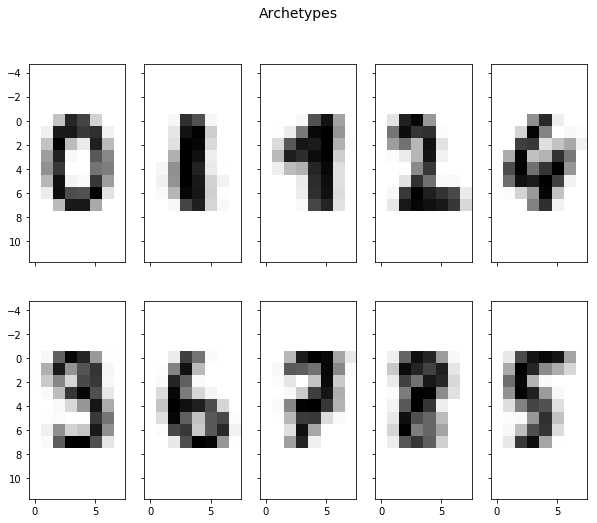

In [2]:
%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt

digits = datasets.load_digits(10)
nSamples = len(digits.images)
data = digits.images.reshape((nSamples, -1))

numberArchetypes = 10

archetypal = ArchetypalAnalysis(
    n_components=numberArchetypes, tmax=50, iterations=20)
archetypal.fit(data)

dataArchetypal = archetypal.transform(data)

archetypes = archetypal.get_archetypes()

f, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(10, 8))
f.suptitle('Archetypes', fontsize=14)

for i in range(2):
    for j in range(5):
        ax[i, j].imshow(
            archetypes[i * 5 + j, :].reshape((8, 8)), cmap='gray_r', interpolation='nearest')

As we can see, seven of the ten archetypes are clearly recognizable as a certain number. Three number are a bit blurry, but they are nevertheless similar to the remaining numbers. This shows that Archetypal Analysis finds the clusters of the dataset, similar to a clustering algorithm.

Next we use Archetypal Analysis as a dimensionality reduction algorithm. As I said the low-dimensional feature points are convex combination of the ten archetypes. That means that each feature point sums to one. We can visualize this ten-dimensional feature space with TSNE. TSNE is ad dimensionality reduction algorithm. It is known to create a visually aesthetic low-dimensional feature space.

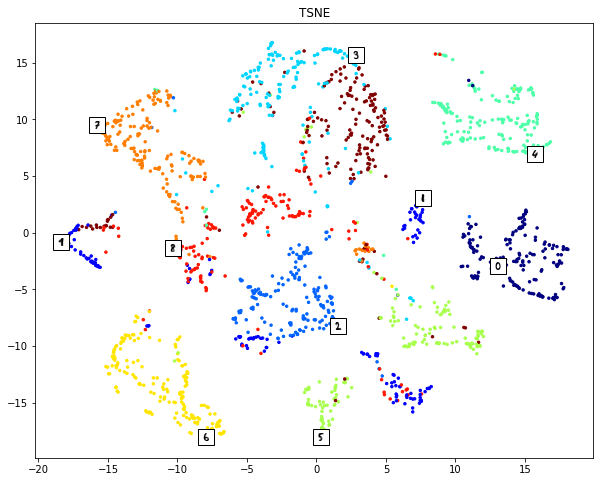

In [3]:
from sklearn.manifold import TSNE
from matplotlib import offsetbox

# create dummy entries for the archetypes
dataArchetypalWithDummy = np.vstack([np.eye(numberArchetypes), dataArchetypal])

tsne = TSNE(n_components=2)
dataArchetypalTSNE = tsne.fit_transform(dataArchetypalWithDummy)

_, ax = plt.subplots(figsize=(10, 8))
ax.set_title('TSNE')

ax.scatter(dataArchetypalTSNE[numberArchetypes:, 0], dataArchetypalTSNE[
           numberArchetypes:, 1], c=digits.target, s=6.0, cmap=plt.cm.get_cmap("jet", 10))
for i in range(np.size(archetypes, axis=0)):
    image = offsetbox.OffsetImage(archetypes[i, :].reshape((8, 8)), cmap='gray_r')
    imagebox = offsetbox.AnnotationBbox(image, dataArchetypalTSNE[i, :])
    ax.add_artist(imagebox)

In the plot above each class is colored differently. We see that the classes cluster. That means that the algorithm preserves the structure of the data points.

A very nice property of the Archetypal Analysis is, that the archetypes have to lie on the convex hull of the data points. This gives us the possibility to plot them into the same TSNE plot. We can use it to understand what each cluster means.

This property can also be used to describe a certain data point. For example the Archetypal Analysis gives a sparse low-dimensional representation of the number four. The biggest value is at the fifth element. That means this image looks like the fifth (the plot with the representation starts counting at zero) archetype, which is infact also the number four.

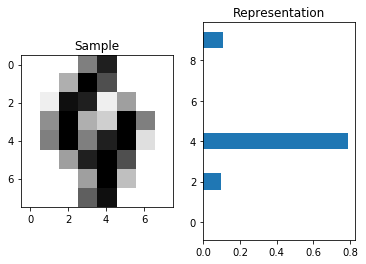

In [4]:
def showRepresentation(sample, representation):
    f, ax = plt.subplots(1, 2)
    ax[0].set_title('Sample')
    ax[0].imshow(
        sample.reshape((8, 8)), cmap='gray_r', interpolation='nearest')

    ax[1].set_title('Representation')
    ax[1].barh(range(numberArchetypes), representation[0, :], align='center')

sample = digits.images[124].reshape((1, -1))
representation = archetypal.transform(sample)

showRepresentation(sample, representation)

Last but not least we can generate new samples from the archetypes. We could create a new number which get 50% of a zero and 50% of a six. And in fact the result is an image with strong parts where both numbers share the same parts, and with weak ones where only one number has a part.

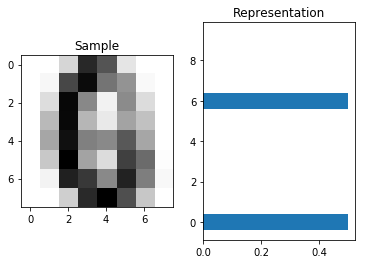

In [5]:
representation = np.array([[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0]])
sample = archetypal.inverse_transform(representation)

showRepresentation(sample, representation)